### MiniRAST Analysis

This is just an example of a couple of fields so we can identify which countries are important. See `RAST Sources` for a full notebook 

In [1]:
# some of these are not needed!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

from PhiSpyAnalysis import theils_u, DateConverter


import subprocess
import gzip


In [2]:
use_small_data = False
if use_small_data:
    phagesdf = pd.read_csv("../small_data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    phagesdf = pd.read_csv("../data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
githash = subprocess.check_output(["git", "describe", "--always"]).strip().decode()
print(f"Please note that this was run with git commit {githash} that has {phagesdf.shape[0]:,} genomes parsed and {phagesdf['Total Predicted Prophages'].sum():,} total prophages")

Please note that this was run with git commit 6f43848 that has 553,082 genomes parsed and 20,946,107 total prophages


### The assembly accession ID column

PATRIC calls the column `assembly_accession` while GTDB calls it `ncbi_genbank_assembly_accession`

In [3]:
acccol = 'assembly_accession'

In [4]:
def get_acc_name(x):
    regexp = re.compile('(\w+\.\d+)_([\w\.\-]+)_genomic.gbff.gz')
    m = regexp.match(x)
    if not m:
        sys.stderr.write(f"WARNING: Regexp did not match {x}\n")
        return (None, None)
    return list(m.groups())

phagesdf = pd.concat([pd.DataFrame.from_records(phagesdf['Contig'].apply(get_acc_name), columns=[acccol, 'Name']), phagesdf['Kept']], axis=1)
phagesdf = phagesdf.drop('Name', axis=1)
phagesdf

,assembly_accession,Kept
0,GCA_000003135.1,2
1,GCA_000003645.1,1
2,GCA_000003925.1,6
3,GCA_000003955.1,6
4,GCA_000005825.2,3
...,...,...
553077,GCA_902860175.1,2
553078,GCA_902860185.1,0
553079,GCA_902860195.1,1
553080,GCA_902860205.1,2


In [5]:
if use_small_data:
    metadf = pd.read_csv("../small_data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    metadf = pd.read_csv("../data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
dc = DateConverter()
metadf['isolation_date'] = metadf.collection_date.apply(dc.convert_date)

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,6,7,8,9,10,11,12,14,19,21,34,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,65) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Filter for only the first of each genome assembly

The metadata contains multiple entries for a genome assembly if it is submitted more than once, so here we just filter for the first instance. We might think about something smarter,  but this seems to work

In [6]:
metadf = metadf.groupby('assembly_accession').first().reset_index()

## Clean up the data

These are specific things in the data that we need to clean/replace.

In [7]:
metadf['isolation_country'] = metadf['isolation_country'].replace('USA', 'United States')
metadf['isolation_country'] = metadf['isolation_country'].replace('Ecully', 'France')
metadf['geographic_location'] = metadf['geographic_location'].replace('USA', 'United States')
metadf['isolation_country'] = metadf['isolation_country'].replace('Adriatic Sea coasts', 'Adriatic Sea')
metadf['isolation_country'] = metadf['isolation_country'].replace('Côte', "Cote d'Ivoire")
metadf['isolation_country'] = metadf['isolation_country'].replace('" Azores"', 'Azores')
metadf['isolation_country'] = metadf['isolation_country'].replace('Democratic Republic of the Congo (Kinshasa)', 'Democratic Republic of the Congo')
metadf['isolation_country'] = metadf['isolation_country'].replace('Hong kong', 'Hong Kong')
metadf['isolation_country'] = metadf['isolation_country'].replace(' Republic of Korea', 'Republic of Korea')
metadf['isolation_country'] = metadf['isolation_country'].replace('Soviet Union', 'USSR')
metadf['isolation_country'] = metadf['isolation_country'].replace('Vietnam', 'Viet Nam')

# Finally replace all None with np.nan
metadf = metadf.fillna(value=np.nan)

## Read some categories

In [8]:
catdf = pd.read_csv("../data/categories.tsv.gz", compression='gzip', header=0, delimiter="\t")
if 'gbff' in catdf:
    catdf = catdf.drop('gbff', axis=1)
catdf = catdf.groupby('assembly_accession').first().reset_index()
catdf

,assembly_accession,Category
0,GCA_000003645.1,food
1,GCA_000003925.1,soil
2,GCA_000003955.1,human blood
3,GCA_000005825.2,soil
4,GCA_000006155.2,human other
...,...,...
54640,GCA_902860175.1,built environment
54641,GCA_902860185.1,human other
54642,GCA_902860195.1,human other
54643,GCA_902860235.1,plant


In [9]:
interesting_cols = [acccol, 'isolation_country', 'isolation_date']

tempdf = metadf[interesting_cols]
# tempdf = metadf[few_interesting_cols]
temp1 = pd.merge(tempdf, catdf, how='left', left_on=acccol, right_on=acccol)
# phagemeta = pd.merge(tempdf, phagesdf, how='inner', left_on=acccol, right_on=acccol)
# phagemeta.to_csv(os.path.join('results', 'example_isolations.tsv'), sep='\t')

phagemeta = pd.merge(temp1, phagesdf, how='right', left_on=acccol, right_on=acccol)
phagemeta

,assembly_accession,isolation_country,isolation_date,Category,Kept
0,GCA_000003135.1,NaN,NaN,NaN,2
1,GCA_000003645.1,NaN,NaN,food,1
2,GCA_000003925.1,NaN,NaN,soil,6
3,GCA_000003955.1,Iceland,NaN,human blood,6
4,GCA_000005825.2,United States,NaN,soil,3
...,...,...,...,...,...
553077,GCA_902860175.1,NaN,1999.956879,built environment,2
553078,GCA_902860185.1,United Kingdom,1999.956879,human other,0
553079,GCA_902860195.1,United Kingdom,1999.956879,human other,1
553080,GCA_902860205.1,NaN,1999.956879,NaN,2


## Encode the data

In [10]:
pmenc = pd.DataFrame()
for c in ['isolation_country', 'Category']:
    pmenc[c] = phagemeta[c].astype('category').cat.codes
pmenc['isolation_date'] = phagemeta['isolation_date'].fillna(-1)
pmenc

,isolation_country,Category,isolation_date
0,-1,-1,-1.000000
1,-1,10,-1.000000
2,-1,46,-1.000000
3,89,14,-1.000000
4,221,46,-1.000000
...,...,...,...
553077,-1,5,1999.956879
553078,220,22,1999.956879
553079,220,22,1999.956879
553080,-1,-1,1999.956879


In [25]:
# print a list of the countries and their IDs for the LOGO analysis.
seen=set()
for index, row in phagemeta.iterrows():
    if pmenc.loc[index, 'isolation_country'] not in seen:
        print(f"{pmenc.loc[index, 'isolation_country']}\t{phagemeta.loc[index, 'isolation_country']}")
        seen.add(pmenc.loc[index, 'isolation_country'])

-1	nan
89	Iceland
221	United States
53	Denmark
20	Bangladesh
148	Norway
41	China
186	South Africa
203	Taiwan
74	Germany
118	Malaya
99	Japan
31	Brazil
220	United Kingdom
97	Italy
150	Pacific Ocean
201	Switzerland
133	Myanmar
189	South Korea
36	Canada
68	France
13	Atlantic Ocean
207	Thailand
137	Netherlands
169	Russia
19	Baltic Sea
136	Nepal
166	Republic of the Congo
75	Ghana
27	Black Sea
14	Australia
9	Arabian Sea
174	Sargasso Sea
88	Hungary
17	Bahamas
139	New Zealand
162	Puerto Rico
145	North Sea
216	USSR
161	Portugal
205	Tanzania
64	Ethiopia
69	French Guiana
157	Peru
212	Tunisia
92	Indonesia
178	Senegal
177	Sea of Korea
146	Northern Ireland
67	Finland
8	Antarctica
151	Pakistan
125	Mediterranean Sea
78	Guadeloupe
158	Philippine Sea
194	Spain
126	Mexico
90	India
164	Red Sea
200	Sweden
82	Gulf of Mexico
175	Saudi Arabia
132	Mozambique
73	Georgia
21	Barbados
184	Solomon Islands
102	Kenya
38	Caribbean Sea
34	Cambodia
84	Haiti
7	Antarctic Ocean
226	Viet Nam
116	Madagascar
65	Faeroe Islands


# Split the data into testing and training sets.

We will keep these sets for later, and do Leave One Group Out (LOGO) validation on the data and use the test set to measure accuracy.

First, lets set out baseline

In [15]:
x_train, x_test, y_train, y_test = train_test_split(pmenc['isolation_country'], phagemeta.Kept.values.ravel())
clf = RandomForestClassifier(random_state=42, n_estimators=1000, bootstrap=True, n_jobs=-1, oob_score=True)
rf = clf.fit(x_train.ravel().reshape(-1,1), y_train)
y_pred=clf.predict(x_test.ravel().reshape(-1,1))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
f1base = metrics.f1_score(y_test, y_pred, average='weighted')
print("f1: ", f1base)

Accuracy: 0.1299043183313927
f1:  0.05964817925176867


In [16]:
if False:
    logo = LeaveOneGroupOut()
    for trainidx, testidx in logo.split(x_train, y_train, groups=x_train):
        print(f"Leaving out {pd.unique(x_train.iloc[testidx].values)}: ", end="")
        clf.fit(x_train.iloc[trainidx].ravel().reshape(-1,1), y_train[trainidx])
        new_pred=clf.predict(x_test.ravel().reshape(-1,1))
        f1measure = metrics.f1_score(y_test, new_pred, average='weighted')
        print(f"f1 delta: {f1base - f1measure}")

In [17]:
fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
impdf

,feature,importance
0,isolation_country,1.0


In [18]:
def number_not_null(x):
    return phagemeta[phagemeta[x.feature].notnull()].shape[0]

fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
impdf["Number of observations"] = impdf.apply(number_not_null, axis=1)
impdf

,feature,importance,Number of observations
0,isolation_country,1.0,96876


([0], [Text(0, 0, '')])

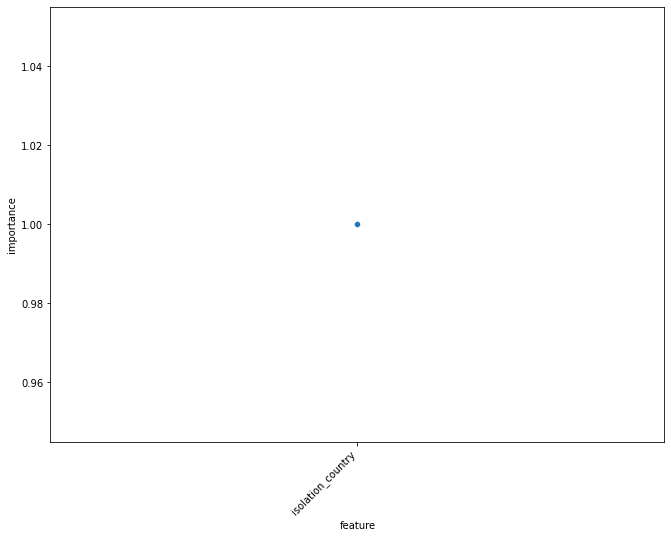

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='feature', y='importance', data=impdf, ax=ax)
plt.xticks(rotation=45,  horizontalalignment='right')

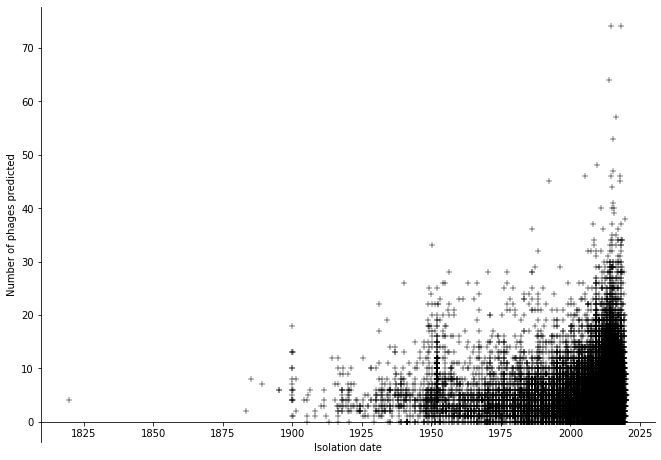

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='isolation_date', y='Kept', data=phagemeta[phagemeta['isolation_date'] != -1], ax=ax, marker='+', color='k')
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation date")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')



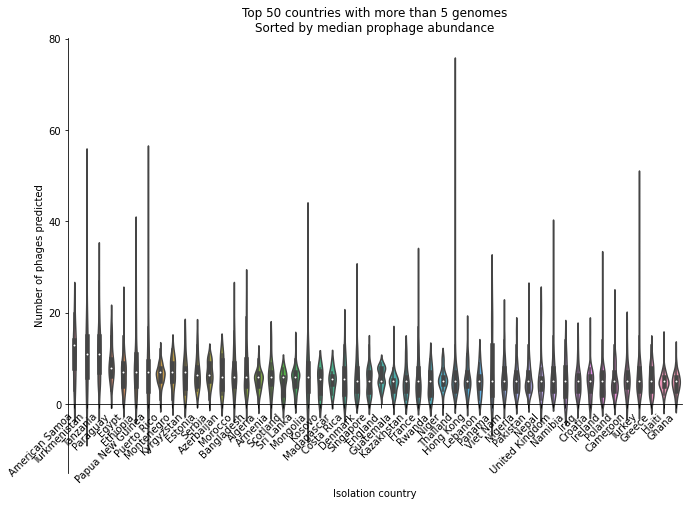

In [21]:
topnc = 50
genomen = 5 
tmpc = pd.DataFrame(phagemeta.groupby('isolation_country').count()['assembly_accession'] > genomen)
tmpc[tmpc['assembly_accession']].index
tmp = phagemeta[phagemeta['isolation_country'].isin(tmpc[tmpc['assembly_accession']].index)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = tmp.groupby('isolation_country')["Kept"].median().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} countries with more than {genomen} genomes\nSorted by median prophage abundance')
l = plt.xticks(rotation=45,  horizontalalignment='right')


## Big Question

Which country(s) are driving the importance of this measure in predicting the number of phages.